# Feature Interaction Constraints

## Why we need Feature Interaction Constraints

When the tree depth is larger than one, many variables interact on the sole basis of minimizing training loss, and the resulting decision tree may capture a spurious relationship (noise) rather than a legitimate relationship that generalizes across different datasets. 

Feature interaction constraints allow users to decide which variables are allowed to interact and which are not.

Potential benefits include:

- Better predictive performance from focusing on interactions that work – whether through domain specific knowledge or algorithms that rank interactions

- Less noise in predictions; better generalization

- More control to the user on what the model can fit. For example, the user may want to exclude some interactions even if they perform well due to regulatory constraints

## Example

- Feature Interaction constraints are expressed in terms of variables that are allowed to interact.

- A constraint [0,1] indicates that variables $x_0$ and $x_1$ are allowed to interact with each other but no other variable.

- A set of feature interaction constraints can be represented as nested list.

- E.g. [[0,1], [2,3,4]] indicate that $x_0$ and $x_1$ can interact with each other. Similarly $x_2 , x_3 $ and $x_4$ can interact with each other.

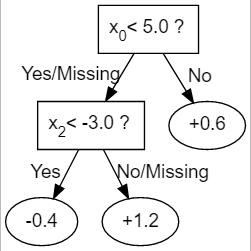 
    
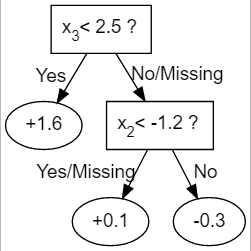

- The first decision tree is wrong. 
- The second decision tree is correct.

## Enforcing feature interaction constraints with XGBoost

 - It is very simple to enforce feature interaction constraints in XGBoost. Here we will give an example using Python, but the same general idea generalizes to other platforms.

In [0]:
model_no_constraints = xgb.train(params, dtrain,
                                 num_boost_round = 1000, evals = evallist,
                                 early_stopping_rounds = 10)

- Then fitting with feature interaction constraints only requires adding a single parameter:

In [0]:
params_constrained = params.copy()
params_constrained['interaction_constraints'] = '[[0, 2], [1, 3, 4], [5, 6]]'
# Features 0 and 2 are allowed to interact with each other but with no other feature
# Features 1, 3, 4 are allowed to interact with one another but with no other feature
# Features 5 and 6 are allowed to interact with each other but with no other feature
model_with_constraints = xgb.train(params_constrained, dtrain,
                                   num_boost_round = 1000, evals = evallist,
                                   early_stopping_rounds = 10)

- Choice of tree construction algorithm. To use feature interaction constraints, be sure to set the tree_method parameter to one of the following: exact, hist, approx or gpu_hist. Support for gpu_hist and approx is added only in 1.0.0.

## Advanced Thoery on Feature Interaction

The intuition behind interaction constraint is simple. User have prior knowledge about relations between different features, and encode it as constraints during model construction. But there are also some subtleties around specifying constraints.

Take constraint [[1, 2], [2, 3, 4]] as an example, the second feature appears in two different interaction sets [1, 2] and [2, 3, 4], so the union set of features allowed to interact with 2 is {1, 3, 4}. 

No matter which feature is chosen for split in root node, all its descendants have to include every feature as legitimate split candidates to avoid violating interaction constraints.

For one last example, we use [[0, 1], [1, 3, 4]] and choose feature 0 as split for root node. 
- At the second layer of built tree, 1 is the only legitimate split candidate except for 0 itself, since they belong to the same constraint set. Following the grow path of our example tree below, the node at second layer splits at feature 1. 
- But due to the fact that 1 also belongs to second constraint set [1, 3, 4], at third layer, we need to include all features as candidates to comply with its ascendants.

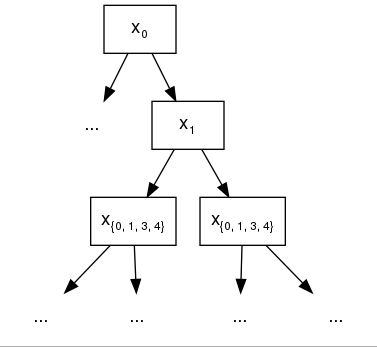